In [1]:
from __future__ import print_function
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import re
import collections
import random
from time import time

from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, FastICA

import data_handler as dh

# plot settings
% matplotlib inline
# print(plt.rcParams.keys())
plt.rcParams['figure.figsize'] = (16,9)

In [2]:
class RNN_Embed(object):
    """ Encapsulation of the dependency RNN lang model
    
    Largely inspired by https://github.com/tensorflow/tensorflow/blob/master/tensorflow/models/rnn/ptb/ptb_word_lm.py
    """
    def __init__(self, config):
#         self.batch_size = config['batch_size']
        self.max_num_steps = config['max_num_steps']
        self.word_embed_size = config['word_embed_size']
        self.dep_embed_size = config['dep_embed_size']
        self.input_size = self.word_embed_size + self.dep_embed_size
        self.hidden_size = 2 * self.word_embed_size #config['hidden_size']
        self.pretrained_word_embeddings = config['pretrained_word_embeddings'] # None if we don't provide them
        if np.any(self.pretrained_word_embeddings):
            assert self.word_embed_size == self.pretrained_word_embeddings.shape[1]
            
        self.max_grad_norm = config['max_grad_norm']
        
        self.vocab_size = config['vocab_size']
        self.dep_vocab_size = config['dep_vocab_size']
        self.name = config['model_name']
        self.checkpoint_prefix = config['checkpoint_prefix'] + self.name
        self.summary_prefix = config['summary_prefix'] + self.name
        
        self.initializer = tf.random_uniform_initializer(-1., 1.)
        with tf.name_scope(self.name):
            with tf.name_scope("Forward"):
                self._build_forward_graph()
            with tf.name_scope("Backward"):
                self._build_train_graph()
            with tf.name_scope("Nearby"):
                self._build_similarity_graph()
        
        self._valid_accuracy = tf.Variable(0.0, trainable=False)
        self._valid_acc_summary = tf.merge_summary([tf.scalar_summary("Valid_accuracy", self._valid_accuracy)])

        self.saver = tf.train.Saver(tf.all_variables())
            
        self.session = tf.InteractiveSession()
        self.session.run(tf.initialize_all_variables())        
        self.summary_writer = tf.train.SummaryWriter(self.summary_prefix, self.session.graph_def)
        
    def save_validation_accuracy(self, new_score):
        assign_op = self._valid_accuracy.assign(new_score)
        _, summary = self.session.run([assign_op, self._valid_acc_summary])
        self.summary_writer.add_summary(summary)
        
    def _build_forward_graph(self):
        # input tensor of zero padded indices to get to max_num_steps
        # None allows for variable batch sizes
        with tf.name_scope("Inputs"):
            self._input_phrases = tf.placeholder(tf.int32, [None, self.max_num_steps, 2]) # [batch_size, w_{1:N}, 2]
            self._input_targets = tf.placeholder(tf.int32, [None, 2]) # [batch_size, w_x]
            self._input_labels = tf.placeholder(tf.int32, [None, 1]) # [batch_size, from true data?] \in {0,1}
            self._input_lengths = tf.placeholder(tf.int32, [None, 1]) # [batch_size, N] (len of each sequence)
            batch_size = tf.shape(self._input_lengths)[0]
        
        with tf.name_scope("Embeddings"):
            if np.any(self.pretrained_word_embeddings):
                self._word_embeddings = tf.Variable(self.pretrained_word_embeddings,name="word_embeddings")
                self._left_target_embeddings = tf.Variable(self.pretrained_word_embeddings, name="left_target_embeddings")
                self._right_target_embeddings = tf.Variable(self.pretrained_word_embeddings, name="right_target_embeddings")
            else:
                self._word_embeddings = tf.get_variable("word_embeddings", 
                                                        [self.vocab_size, self.word_embed_size],
                                                        dtype=tf.float32)
                self._left_target_embeddings = tf.get_variable("left_target_embeddings", 
                                                        [self.vocab_size, self.word_embed_size],
                                                        dtype=tf.float32)
                self._right_target_embeddings = tf.get_variable("right_target_embeddings", 
                                                        [self.vocab_size, self.word_embed_size],
                                                        dtype=tf.float32)
            
            self._dependency_embeddings = tf.get_variable("dependency_embeddings", 
                                                    [self.dep_vocab_size, self.dep_embed_size],
                                                    dtype=tf.float32)
            # TODO: Add POS embeddings
            
            input_embeds = tf.nn.embedding_lookup(self._word_embeddings, 
                                                  tf.slice(self._input_phrases, [0,0,0], [-1, -1, 1]))
            dep_embeds = tf.nn.embedding_lookup(self._dependency_embeddings,
                                                tf.slice(self._input_phrases, [0,0,1], [-1, -1, 1]))
            left_target_embeds = tf.nn.embedding_lookup(self._left_target_embeddings, 
                                                        tf.slice(self._input_targets, [0,0], [-1, 1]))
            right_target_embeds = tf.nn.embedding_lookup(self._right_target_embeddings, 
                                                        tf.slice(self._input_targets, [0,1], [-1, 1]))
#             print(tf.slice(self._input_phrases, [0,0,1], [-1, -1, 1]).get_shape(), dep_embeds.get_shape())
#             print(left_target_embeds.get_shape(), right_target_embeds.get_shape())
            self._target_embeds = tf.squeeze(tf.concat(2, [left_target_embeds, right_target_embeds]), [1])
#             print(target_embeds.get_shape())
            # TODO: Add dropout to embeddings
        
        with tf.name_scope("RNN"):
            # start off with a basic configuration
            self.cell = tf.nn.rnn_cell.GRUCell(self.hidden_size, 
                                                input_size=self.input_size)
            # TODO: Add Dropout wrapper
            # TODO: Make it multilevel
#             self._initial_state = self.cell.zero_state(batch_size, tf.float32)
#             print(self._initial_state.get_shape())
            input_words = [ tf.squeeze(input_, [1, 2]) for input_ in tf.split(1, self.max_num_steps, input_embeds)]
            input_deps = [ tf.squeeze(input_, [1, 2]) for input_ in tf.split(1, self.max_num_steps, dep_embeds)]
            inputs = [ tf.concat(1, [input_word, input_dep]) 
                      for (input_word, input_dep) in zip(input_words, input_deps)]

            _, state = tf.nn.rnn(self.cell, inputs, 
                                 sequence_length=tf.squeeze(self._input_lengths, [1]),
                                 dtype=tf.float32)
#                                  initial_state=self._initial_state)
            self._final_state = state
            
        with tf.name_scope("Loss"):
            flat_states = tf.reshape(state, [-1])
            flat_target_embeds = tf.reshape(self._target_embeds, [-1])
#             assert self.hidden_size == (self.word_embed_size), "Hidden state must equal concated inputs" 
            flat_logits = tf.mul(flat_states, flat_target_embeds)
            logits = tf.reduce_sum(tf.reshape(flat_logits, tf.pack([batch_size, -1])), 1)
            self._loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits, 
                                                                    tf.to_float(self._input_labels)))
            
        with tf.name_scope("Summaries"):
            
            self._train_cost_summary = tf.merge_summary([tf.scalar_summary("Train_NEG_Loss", self._loss)])
            self._valid_cost_summary = tf.merge_summary([tf.scalar_summary("Validation_NEG_Loss", self._loss)])
        
    def _build_train_graph(self):
        with tf.name_scope("Trainer"):
            self._global_step = tf.Variable(0, name="global_step", trainable=False)
#             self._lr = tf.Variable(1.0, trainable=False)
            self._optimizer = tf.train.AdagradOptimizer(1.0)
            
            # clip and apply gradients
            grads_and_vars = self._optimizer.compute_gradients(self._loss)
#             for gv in grads_and_vars:
#                 print(gv, gv[1] is self._cost)
            clipped_grads_and_vars = [(tf.clip_by_norm(gv[0], self.max_grad_norm), gv[1]) 
                                      for gv in grads_and_vars if gv[0] is not None] # clip_by_norm doesn't like None
            
            with tf.name_scope("Summaries"):
                grad_summaries = []
                for g, v in grads_and_vars:
                    if g is not None:
                        grad_hist_summary = tf.histogram_summary("{}/grad/hist".format(v.name), g)
                        sparsity_summary = tf.scalar_summary("{}/grad/sparsity".format(v.name), tf.nn.zero_fraction(g))
                        grad_summaries.append(grad_hist_summary)
                        grad_summaries.append(sparsity_summary)
                self._grad_summaries = tf.merge_summary(grad_summaries)
            self._train_op = self._optimizer.apply_gradients(clipped_grads_and_vars, global_step=self._global_step)
            
    def _build_similarity_graph(self):
        tf.get_variable_scope().reuse_variables()
        with tf.name_scope("Inputs"):
            # word or phrase we want similarities for
#             self._query_word = tf.placeholder(tf.int32, [1], name="q_word")
            self._query_phrase = tf.placeholder(tf.int32, [self.max_num_steps, 2], name="q_phrase")
            self._query_length = tf.placeholder(tf.int32, [1], name="q_len") # lengths for RNN
            # words and phrases to compute similarities over
#             self._sim_words = tf.placeholder(tf.int32, [None, 1])
            self._sim_phrases = tf.placeholder(tf.int32, [None, self.max_num_steps, 2])
            self._sim_lengths = tf.placeholder(tf.int32, [None, 1]) # lengths for RNN
            sim_size = tf.shape(self._sim_lengths)[0]
        
        with tf.name_scope("Embeddings"):
            query_phrase_embed = tf.nn.embedding_lookup(self._word_embeddings, 
                                                  tf.slice(self._query_phrase, [0,0], [-1, 1]))
            query_dep_embed = tf.nn.embedding_lookup(self._dependency_embeddings,
                                                tf.slice(self._query_phrase, [0,1], [-1, 1]))
#             query_word_embed = tf.nn.embedding_lookup(self._word_embeddings, self._query_word)
#             query_phrase_embed = tf.nn.embedding_lookup(self._word_embeddings, self._query_phrase)
#             sim_word_embed = tf.nn.embedding_lookup(self._word_embeddings, tf.squeeze(self._sim_words, [1]))
            sim_phrase_embed = tf.nn.embedding_lookup(self._word_embeddings, 
                                                  tf.slice(self._sim_phrases, [0, 0, 0], [-1, -1, 1]))
            sim_dep_embed = tf.nn.embedding_lookup(self._dependency_embeddings, 
                                                  tf.slice(self._sim_phrases, [0, 0, 1], [-1, -1, 1]))
        
        with tf.name_scope("RNN"):
            # compute rep of a query phrase
            query_phrase = [tf.squeeze(qw, [1]) for qw in tf.split(0, self.max_num_steps, query_phrase_embed)]
            query_dep = [tf.squeeze(qd, [1]) for qd in tf.split(0, self.max_num_steps, query_dep_embed)]
#             print(query_phrase[0].get_shape(), query_dep[0].get_shape())
            query_input = [ tf.concat(1, [qw, qd]) for (qw, qd) in zip(query_phrase, query_dep)]
            _, query_phrase_state = tf.nn.rnn(self.cell, query_input, 
                                              sequence_length=self._query_length, 
                                              dtype=tf.float32)
            # compute reps of similarity phrases
            sim_phrases = [tf.squeeze(qw, [1,2]) for qw in tf.split(1, self.max_num_steps, sim_phrase_embed)]
            sim_deps = [tf.squeeze(qd, [1,2]) for qd in tf.split(1, self.max_num_steps, sim_dep_embed)]
            sim_input = [ tf.concat(1, [qw, qd]) for (qw, qd) in zip(sim_phrases, sim_deps)]
            _, sim_phrase_states = tf.nn.rnn(self.cell, sim_input, 
                                             sequence_length=tf.squeeze(self._sim_lengths, [1]), 
                                             dtype=tf.float32)
            
        with tf.name_scope("Similarities"):
            with tf.name_scope("Normalize"):
#                 print(query_phrase.get_shape())
                query_phrase = tf.nn.l2_normalize(query_phrase_state, 1)
#                 query_word = tf.nn.l2_normalize(query_word_embed, 1)
                sim_phrases = tf.nn.l2_normalize(sim_phrase_states, 1)
#                 sim_word = tf.nn.l2_normalize(sim_word_embed, 1)                

            with tf.name_scope("Calc_distances"):
                # do for words
#                 print(q)
#                 query_word_nearby_dist = tf.matmul(query_word, sim_word, transpose_b=True)
#                 qw_nearby_val, qw_nearby_idx = tf.nn.top_k(query_word_nearby_dist, min(1000, self.vocab_size))
#                 self.qw_nearby_val = tf.squeeze(qw_nearby_val)
#                 self.qw_nearby_idx = tf.squeeze(qw_nearby_idx)
#                 self.qw_nearby_words = tf.squeeze(tf.gather(self._sim_words, qw_nearby_idx))

                # do for phrases
                query_phrase_nearby_dist = tf.matmul(query_phrase, sim_phrases, transpose_b=True)
                qp_nearby_val, qp_nearby_idx = tf.nn.top_k(query_phrase_nearby_dist, min(1000, sim_size))
#                 self.sanity_check = tf.squeeze(tf.matmul(query_phrase, query_phrase, transpose_b=True))
                self.qp_nearby_val = tf.squeeze(qp_nearby_val)
                self.qp_nearby_idx = tf.squeeze(qp_nearby_idx)
#                 self.qp_nearby_lens = tf.squeeze(tf.gather(self._sim_lengths, qp_nearby_idx))
            
    def partial_fit(self, input_phrases, input_targets, input_labels, input_lengths):
        """Fit a mini-batch
        
        Expects a batch_x: [self.batch_size, self.max_num_steps]
                  batch_y: the same
                  batch_seq_lens: [self.batch_size]
                  
        Returns average batch perplexity
        """
        loss, _, g_summaries, c_summary = self.session.run([self._loss, self._train_op, 
                                                            self._grad_summaries,
                                                            self._train_cost_summary],
                                                           {self._input_phrases:input_phrases,
                                                            self._input_targets:input_targets,
                                                            self._input_labels:input_labels,
                                                            self._input_lengths:input_lengths})
        self.summary_writer.add_summary(g_summaries)
        self.summary_writer.add_summary(c_summary)
        return loss
    
    def validation_loss(self, valid_phrases, valid_targets, valid_labels, valid_lengths):
        """Calculate loss on validation inputs, but don't run trainer"""
        loss, v_summary = self.session.run([self._loss, self._valid_cost_summary],
                                           {self._input_phrases:valid_phrases,
                                            self._input_targets:valid_targets,
                                            self._input_labels:valid_labels,
                                            self._input_lengths:valid_lengths})
        self.summary_writer.add_summary(v_summary)
        return loss
    
    def validation_phrase_nearby(self, q_phrase, q_phrase_len, sim_phrases, sim_phrase_lens):
        """Return nearby phrases from the similarity set
        """
        nearby_vals, nearby_idx = self.session.run([self.qp_nearby_val, self.qp_nearby_idx],
                                                                   {self._query_phrase:q_phrase, 
                                                                    self._query_length:q_phrase_len,
                                                                    self._sim_phrases:sim_phrases,
                                                                    self._sim_lengths:sim_phrase_lens})
#         print("Sanity check: %r" % sanity)
        return nearby_vals, nearby_idx
    
    def embed_phrases_and_targets(self, phrases, targets, lengths):
        phrase_reps, target_reps = self.session.run([self._final_state, self._target_embeds],
                                                    { self._input_phrases:phrases,
                                                      self._input_targets:targets,
                                                      self._input_lengths:lengths})
        return phrase_reps, target_reps
    
#     def validation_word_nearby(self, q_word, sim_words):
#         """Return nearby phrases from the similarity set
#         """
#         nearby_vals, nearby_idx = self.session.run([self.qw_nearby_val, 
#                                                       self.qw_nearby_idx],
#                                                        {self._query_word:q_word, 
#                                                         self._sim_words:sim_words})
#         return nearby_vals, nearby_idx
        
    def predict(self, sequences, seq_lens, return_probs=False):
        if return_probs:
            predictions, distributions = self.session.run([self._predictions, self._predicted_dists],
                                                          {self._predict_inputs:sequences,
                                                           self._predict_lengths:seq_lens})
            distributions = distributions.reshape([sequences.shape[0], sequences.shape[1], -1])
            pred_list = []
            dist_list = []
            for i, seq_len in enumerate(seq_lens):
                pred_list.append(list(predictions[i, :seq_len]))
                dist_list.append([distributions[i,j,:] for j in range(seq_len)])
            return pred_list, dist_list
        
        else:
            predictions = self.session.run(self._predictions,
                                           {self._predict_inputs:sequences,
                                            self._predict_lengths:seq_lens})
            pred_list = []
            for i, seq_len in enumerate(seq_lens):
                pred_list.append(list(predictions[i, :seq_len])) 
            return pred_list
            
    def checkpoint(self):
        self.saver.save(self.session, self.checkpoint_prefix + '.ckpt', global_step=self._global_step)
        
    def restore(self, model_ckpt_path):
        self.saver.restore(self.session, model_ckpt_path)
        
    def __repr__(self):
        return ("<DPNN: W:%i, D:%i, H:%i, V:%i>" 
                % (self.word_embed_size, self.dep_embed_size, self.hidden_size, self.vocab_size))


In [3]:
reload(dh)
DH = dh.DataHandler('data/shuffled_wiki_sdp_50000', valid_percent=1)

Creating Data objects...
Done creating Data objects
549604 total examples :: 544107 training : 5497 valid (99:1 split)
Vocab size: 22265 Dep size: 46


In [4]:
# print(DH.max_seq_len)
# paths, targets = DH.readable_data(show_dep=True)
# for p, t in zip(paths, targets) :
#     t = t.split(", ")
#     print("%s (%s) %s" % (t[0], p, t[1]))

In [5]:
%time
# load the pretrained word embeddings
fname = 'data/GoogleNews-vectors-negative300.bin'
word2vec = Word2Vec.load_word2vec_format(fname, binary=True)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 3.1 µs


In [6]:
# the embedding matrix is started of as random uniform [-1,1]
# then we replace everything but the OOV tokens with the approprate google vector
word_embeddings = np.random.uniform(low=-1., high=1., size=[DH.vocab_size, 300]).astype(np.float32)
num_found = 0
for i, token in enumerate(DH.vocab):
    if token in word2vec:
        word_embeddings[i] = word2vec[token]
        num_found += 1
print("%i / %i pretrained" % (num_found, DH.vocab_size))

18498 / 22265 pretrained


In [7]:
config = {
    'max_num_steps':DH.max_seq_len,
    'word_embed_size':300,
    'dep_embed_size':25,
    'vocab_size':DH.vocab_size,
    'dep_vocab_size':DH.dep_size,
    'pretrained_word_embeddings':word_embeddings,
    'max_grad_norm':3.,
    'model_name':'drnn_wiki_w2v',
    'checkpoint_prefix':'checkpoints/',
    'summary_prefix':'tensor_summaries/'
}
try:
    tf.reset_default_graph()
except:
    pass
try:
    tf.get_default_session().close()
except:
    pass
drnn = RNN_Embed(config)
print(drnn)

<DPNN: W:300, D:25, H:600, V:22265>


In [8]:
def run_validation_test(num_nearby=20):
    valid_phrases, _, _, valid_lens = DH.validation_batch()
    random_index = int(random.uniform(0, len(valid_lens)))
    query_phrase = valid_phrases[random_index]
    query_len = valid_lens[random_index]
    padded_qp = np.zeros([DH.max_seq_len, 2]).astype(np.int32)
    padded_qp[:len(query_phrase), 0] = [x[0] for x in query_phrase]
    padded_qp[:len(query_phrase), 1] = [x[1] for x in query_phrase]    
    dists, phrase_idx = drnn.validation_phrase_nearby(padded_qp, query_len, valid_phrases, valid_lens)
    print("="*80)
    print("Top %i closest phrases to '%s'" % (num_nearby, DH.sequence_to_sentence(query_phrase, query_len)))
    for i in range(num_nearby):
        dist = dists[i]
        phrase = valid_phrases[phrase_idx[i]]
        len_ = valid_lens[phrase_idx[i]]
        print("%i: %0.3f : '%s'" % (i, dist,DH.sequence_to_sentence(phrase, len_)))
    print("="*80)
#     drnn.save_validation_accuracy(frac_correct)

In [9]:
def time_left(num_epochs, num_steps, fit_time, nearby_time, start_time, nearby_mod):
    total = num_epochs*num_steps*fit_time + ((num_epochs*num_steps)/float(nearby_mod))*nearby_time
    return total - (time() - start_time)

In [ ]:
# hyperparameters
num_epochs = 5
batch_size =50
neg_per = 20
num_nearby = 20
nearby_mod = 50
sample_power = .75
DH.scale_vocab_dist(sample_power)

# bookkeeping
num_steps = DH.num_steps(batch_size)
total_step = 1
save_interval = 30 * 60 # half hour in seconds
save_time = time()

#timing stuff
start = time()
fit_time = 0
nearby_time = 0

for epoch in range(num_epochs):
    DH.shuffle_data()
    for step , batch in enumerate(DH.batches(batch_size, neg_per=neg_per)):
        t0 = time()
        loss = drnn.partial_fit(*batch)
        fit_time = (fit_time * float(total_step) +  time() - t0) / (total_step + 1) # running average
        if step % 10 == 0:
            m,s = divmod(time()-start, 60)
            h,m = divmod(m, 60)
            left = time_left(num_epochs, num_steps, fit_time, nearby_time, start, nearby_mod)
            ml,sl = divmod(left, 60)
            hl,ml = divmod(ml, 60)
            pps = batch_size*(neg_per + 1) / fit_time 
            print("(%i:%i:%i) step %i/%i, epoch %i Training Loss = %1.5f :: %0.3f phrases/sec :: (%i:%i:%i) hours left" 
                  % (h,m,s, step, num_steps, epoch, loss, pps, hl, ml, sl))
        if (total_step-1) % nearby_mod == 0: # do one right away so we get a good timing estimate
            t0 = time()
            run_validation_test(num_nearby) # check out the nearby phrases in the validation set
            valid_loss = drnn.validation_loss(*DH.validation_batch())
            print("Validation loss: %0.4f" % valid_loss)
            nearby_time = (nearby_time * float(total_step) + time() - t0) / (total_step + 1) # running average

        if (time() - save_time) > save_interval:
            print("Saving model...")
            drnn.checkpoint()
            save_time = time()
        total_step +=1
drnn.checkpoint()

(0:0:3) step 0/10882, epoch 0 Training Loss = 0.68010 :: 1230.223 phrases/sec :: (12:53:55) hours left
Top 20 closest phrases to 'introduce concept to'
0: 1.000 : 'introduce concept to'
1: 0.978 : 'toward raising introduce to'
2: 0.977 : 'provide to'
3: 0.976 : 'providing to'
4: 0.976 : 'presented to'
5: 0.975 : 'added to'
6: 0.975 : 'come to'
7: 0.975 : 'model being to'
8: 0.974 : 'be to'
9: 0.974 : 'one makes to to'
10: 0.974 : 'sees promoting to'
11: 0.974 : 'comes to'
12: 0.974 : 'back to'
13: 0.973 : 'from to'
14: 0.973 : 'from to'
15: 0.973 : 'from to'
16: 0.973 : 'from to'
17: 0.973 : 'from to'
18: 0.973 : 'from to'
19: 0.973 : 'from to'
Validation loss: 1.3547


In [334]:
drnn.checkpoint()

In [380]:
# test the embeddings

### VALID ###
# valid_phrases, valid_targets, _, valid_lens = DH.validation_batch()
# phrase_embeds, target_embeds = drnn.embed_phrases_and_targets(valid_phrases, valid_targets, valid_lens)
# phrase_labels, target_labels = DH.readable_data(valid=True)

### TRAIN ###
train_phrases, train_targets, _, train_lens = DH.batches(500, neg_per=0, offset=0).next()
phrase_embeds, target_embeds = drnn.embed_phrases_and_targets(train_phrases, train_targets, train_lens)
phrase_labels, target_labels = DH.readable_data(show_dep=True, valid=False)
        
phrase_embeds /= np.sqrt(np.sum(phrase_embeds**2, 1, keepdims=True))
target_embeds /= np.sqrt(np.sum(target_embeds**2, 1, keepdims=True))

0
u'Germany, Poland', u'(the, conj) (,, conj)'
11
u'Germany, Poland', u'(participate, conj) (staff, conj)'
33
u'Germany, Poland', u'(team, conj) (35, conj)'
177
u'Germany, Poland', u'(,, conj) (existence, conj)'
187
u'Germany, Poland', u'(to, conj) (6th, conj)'
244
u'Germany, Poland', u'(the, conj) (New, conj)'
400
u'Germany, Poland', u'(has, conj) (application, conj)'
409
u'Germany, Poland', u'(), conj) (1976, conj)'
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


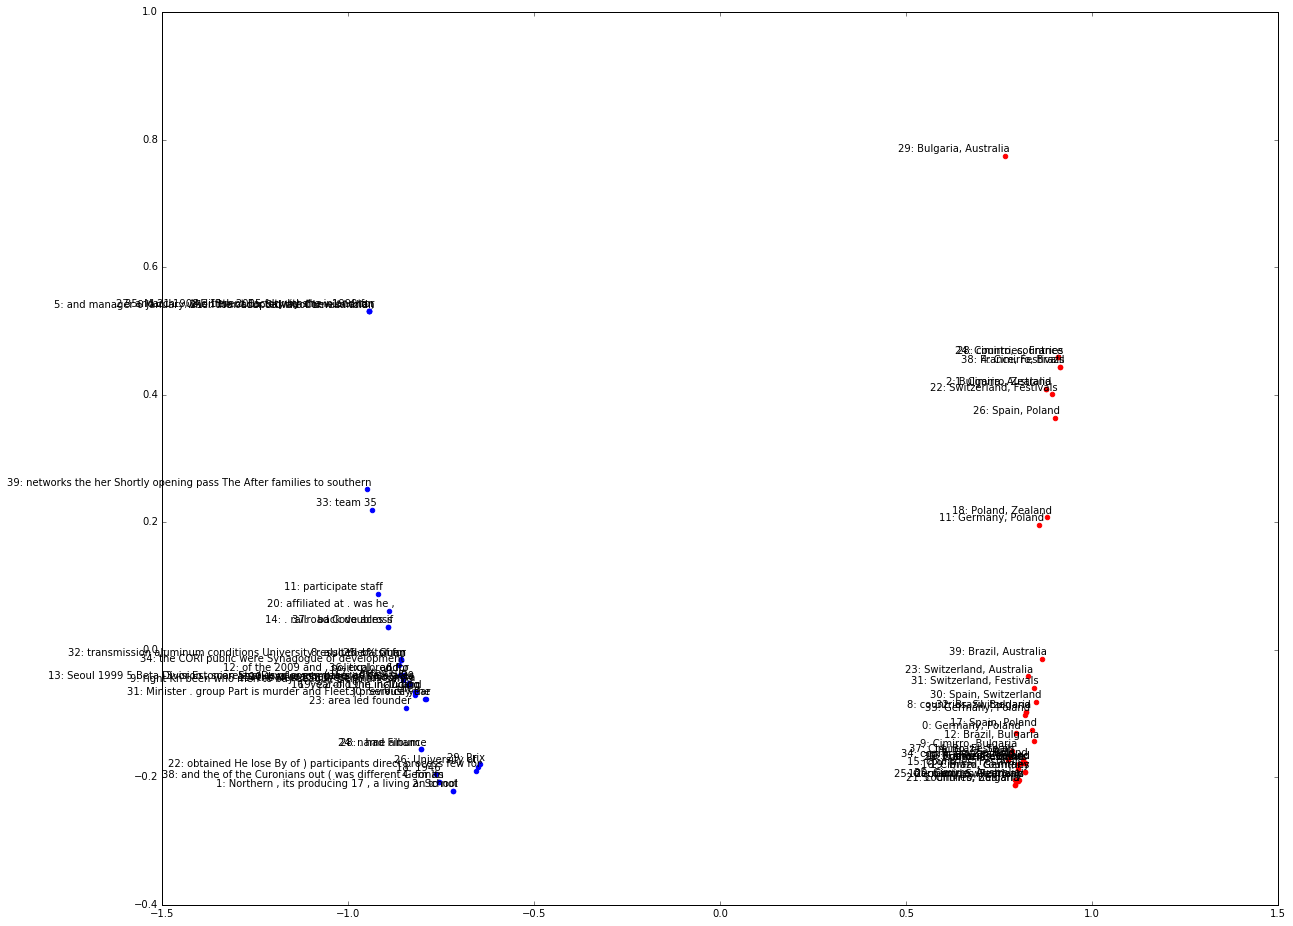

In [340]:
### JOINT ###
start = 0
stride = 40
end = start + stride

# lowd = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
lowd = PCA(n_components=2)

joint_embeds = np.vstack([phrase_embeds[start:end], target_embeds[start:end]])
joint_2d = lowd.fit_transform(joint_embeds)
phrase_2d, target_2d = joint_2d[:stride], joint_2d[stride:]

fig, ax = plt.subplots(figsize=(20,16))
for i, label in enumerate(phrase_labels[start:end]):
    label = "%i: %s" % (i, label)
    x, y = phrase_2d[i,:]
    ax.scatter(x, y, color='b')
    ax.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
for i, label in enumerate(target_labels[start:end]):
    label = "%i: %s" % (i, label)
    x, y = target_2d[i,:]
    ax.scatter(x, y, color='r')
    ax.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')

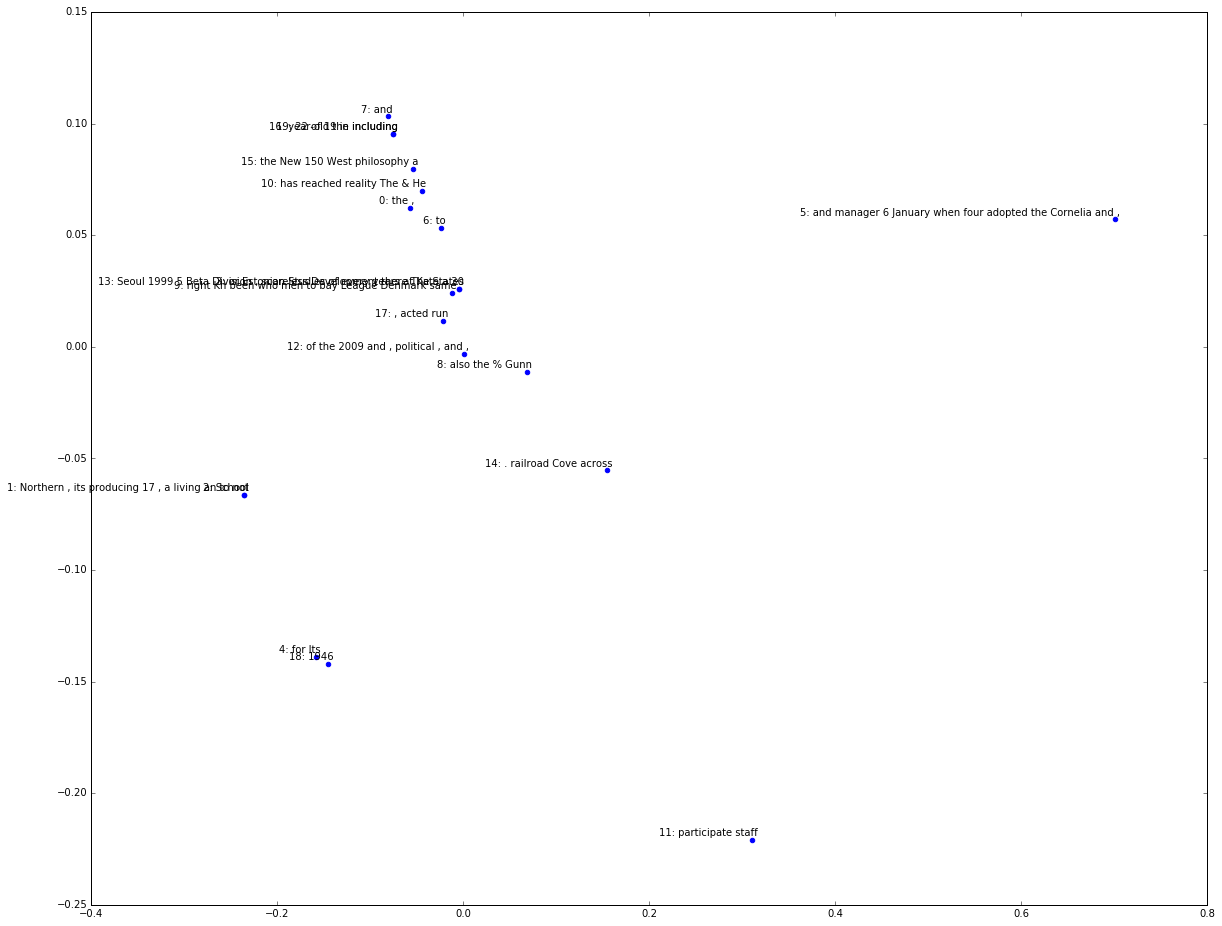

In [368]:
### PHRASE ONLY ###
start = 0
stride = 20
end = start + stride

# lowd = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
lowd = PCA(n_components=2)

phrase_2d = lowd.fit_transform(phrase_embeds[start:end])

fig, ax = plt.subplots(figsize=(20,16))
for i, label in enumerate(phrase_labels[start:end]):
    label = "%i: %s" % (i, label)
    x, y = phrase_2d[i,:]
    ax.scatter(x, y, color='b')
    ax.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')

/Users/thomaseffland/.virtualenvs/rel/lib/python2.7/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


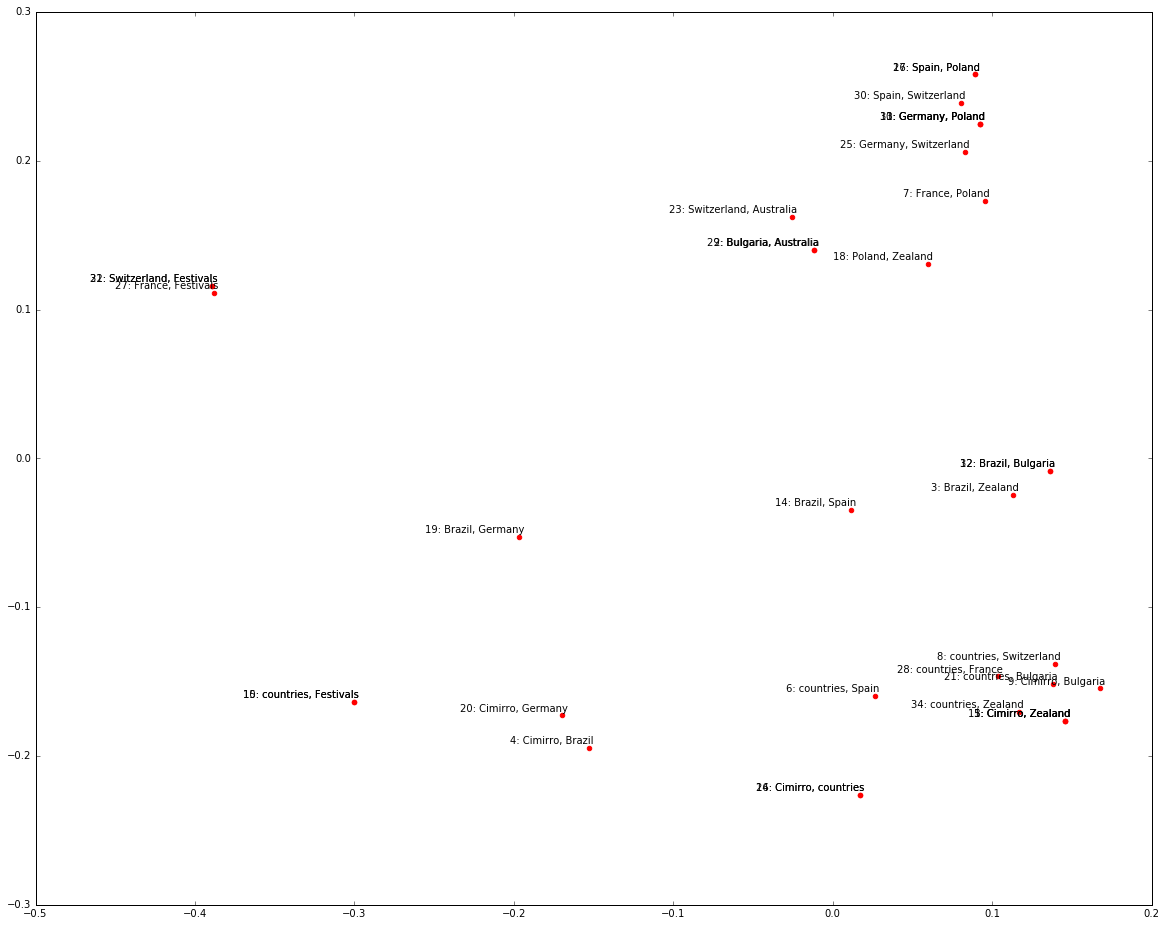

In [386]:
### TARGET ONLY ###
start = 0
stride = 35
end = start + stride

# lowd = TSNE(perplexity=20, n_components=2, init='pca', n_iter=5000)
lowd = PCA(n_components=2)

target_2d = lowd.fit_transform(target_embeds[start:end])

fig, ax = plt.subplots(figsize=(20,16))
for i, label in enumerate(target_labels[start:end]):
    label = "%i: %s" % (i, label)
    x, y = target_2d[i,:]
    ax.scatter(x, y, color='r')
    ax.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')

In [345]:
from spacy.en import English

In [346]:
nlp = English()

In [392]:
s = nlp(u"It was replaced in 2006 by the Combined Joint Operations from the Sea Center of Excellence .")

In [395]:
for chunk in s.noun_chunks:b
    print(chunk)

It
the Combined Joint Operations
the Sea Center
Excellence


In [414]:
a = np.array([1,2])
np.any(a)

True

In [417]:
print(np.any(None))

None
